In [12]:
import os
import json
import re
import pandas as pd

def parse_jsonl(data):
    parsed_data = []
    for line in data:
        parsed_data.append(json.loads(line))

    return parsed_data

def get_main_df(path, file_in_question):

    main_df = pd.DataFrame()
    for root, dirs, files in os.walk(path):
        if "layer" not in root:
            continue

        for file in files:

            if file == file_in_question:
                with open(os.path.join(root, file)) as f:
                    data = f.readlines()


                parsed_data = parse_jsonl(data)
                df = pd.DataFrame(parsed_data)
                
                # We have tp, fp, tn, fn
                # We want precision, recall, f1
                df["precision"] = df["tp"] / (df["tp"] + df["fp"])
                df["recall"] = df["tp"] / (df["tp"] + df["fn"])
                df["f1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])
                df["accuracy"] = (df["tp"] + df["tn"]) / (df["tp"] + df["tn"] + df["fp"] + df["fn"])
                df["layer"] = re.search(r"layer(\d+)", root).group(1)

                main_df = pd.concat([main_df, df])

    return main_df
def get_best(main_df):
    best_accuracy = main_df[main_df["accuracy"] == main_df["accuracy"].max()]["accuracy"]
    best_f1 = main_df[main_df["f1"] == main_df["f1"].max()]["f1"]
    layer = main_df[main_df["f1"] == main_df["f1"].max()]["layer"]
    print(f"Best layer: {layer.values[0]}")
    return best_accuracy, best_f1, main_df[main_df["f1"] == main_df["f1"].max()]


path = "gpt2_gbug-java"
file_in_question = "decision_tree.jsonl"
main_df = get_main_df(path, file_in_question)
best_accuracy, best_f1, main_df = get_best(main_df)
print(f"For {file_in_question} in {path}")
print(f"BEST F1: {best_f1}")
print(f"BEST ACCURACY: {best_accuracy}")
# file_in_question = "logistic_regression.jsonl"
# main_df = get_main_df(path, file_in_question)
# best_accuracy, best_f1 = get_best(main_df)
# print(f"For {file_in_question} in {path}")
# print(f"BEST F1: {best_f1}")
# print(f"BEST ACCURACY: {best_accuracy}")
main_df

Best layer: 10
For decision_tree.jsonl in gpt2_gbug-java
BEST F1: 75    0.862069
79    0.862069
Name: f1, dtype: float64
BEST ACCURACY: 75    0.866667
79    0.866667
Name: accuracy, dtype: float64


,classifier,n_features,tp,fp,tn,fn,y_pred,y_test,precision,recall,f1,accuracy,layer,best_params,dataset
75,decision_tree,76,25,3,27,5,"[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.892857,0.833333,0.862069,0.866667,10,NaN,NaN
79,decision_tree,80,25,3,27,5,"[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ...","[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ...",0.892857,0.833333,0.862069,0.866667,10,NaN,NaN


In [3]:
top_k_to_show = main_df["n_features"].unique().tolist()
# create a table with the top k values as columns and the layers as rows. write the f1 values in the cells
table = pd.DataFrame()
for k in top_k_to_show:
    table[k] = main_df[main_df["n_features"] == k].set_index("layer")["accuracy"]


# convert the index into integers
table.index = table.index.astype(int)

# sort the rows by the index
table = table.sort_index()
table

,1,5,10,20,50,100,200,500,1000,2000,5000,10000
layer,,,,,,,,,,,,
0,0.510753,0.526882,0.543011,0.526882,0.435484,0.516129,0.478495,0.462366,0.505376,0.500000,0.516129,0.494624
1,0.510753,0.456989,0.473118,0.483871,0.500000,0.500000,0.446237,0.532258,0.548387,0.489247,0.510753,0.510753
2,0.505376,0.489247,0.553763,0.505376,0.435484,0.516129,0.494624,0.489247,0.516129,0.473118,0.510753,0.462366
3,0.510753,0.483871,0.435484,0.526882,0.543011,0.483871,0.500000,0.467742,0.494624,0.500000,0.462366,0.510753
4,0.500000,0.489247,0.516129,0.505376,0.489247,0.473118,0.505376,0.473118,0.440860,0.451613,0.505376,0.473118
5,0.478495,0.500000,0.489247,0.510753,0.521505,0.473118,0.516129,0.543011,0.526882,0.543011,0.521505,0.553763
6,0.526882,0.505376,0.478495,0.494624,0.500000,0.467742,0.505376,0.473118,0.510753,0.473118,0.473118,0.483871
7,0.516129,0.430108,0.532258,0.537634,0.451613,0.537634,0.532258,0.494624,0.500000,0.521505,0.510753,0.483871
8,0.537634,0.521505,0.526882,0.516129,0.532258,0.543011,0.483871,0.483871,0.473118,0.505376,0.516129,0.500000


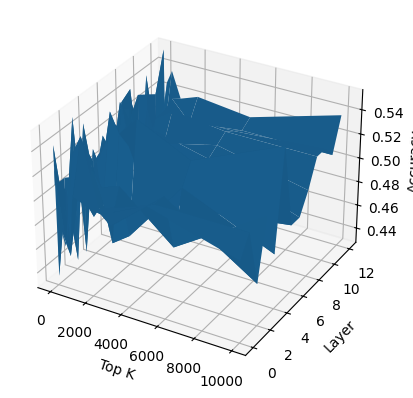

In [4]:
# plot the table in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.array(table.columns)
y = np.array(table.index)
X, Y = np.meshgrid(x, y)
Z = np.array(table)

ax.plot_surface(X, Y, Z)
# add axis labels
ax.set_xlabel('Top K')
ax.set_ylabel('Layer')
ax.set_zlabel('Accuracy')
plt.show()





In [5]:
table_copy = table.copy()
table_copy = table_copy.reset_index()
table_copy = table_copy.melt(id_vars="layer", var_name="n_features", value_name="accuracy")
table_copy["n_features"] = table_copy["n_features"].astype(int)
table_copy["layer"] = table_copy["layer"].astype(int)
table_copy

,layer,n_features,accuracy
0,0,1,0.510753
1,1,1,0.510753
2,2,1,0.505376
3,3,1,0.510753
4,4,1,0.500000
...,...,...,...
151,8,10000,0.500000
152,9,10000,0.521505
153,10,10000,0.521505
154,11,10000,0.510753


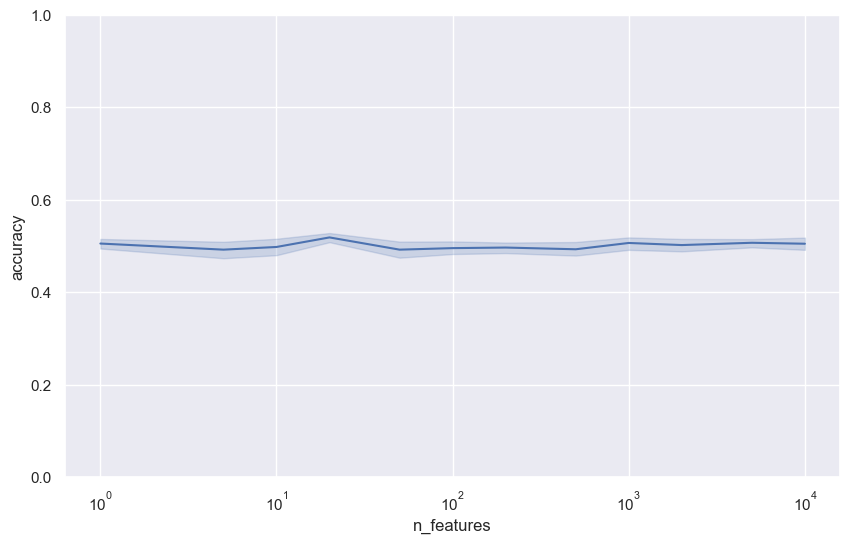

In [6]:
# plot the table in 2d with confidence intervals
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(10, 6))
sns.lineplot(data=table_copy, x="n_features", y="accuracy")


# set y axis limits
plt.ylim(0, 1)

# make the x axis log scale
plt.xscale("log")


plt.show()


/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_35516/3383640940.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=main_df, x="n_features", y=ACTIVE_METRIC.name, ci=95, label=f"Mean {ACTIVE_METRIC.label}", color="black", linestyle="dashed")


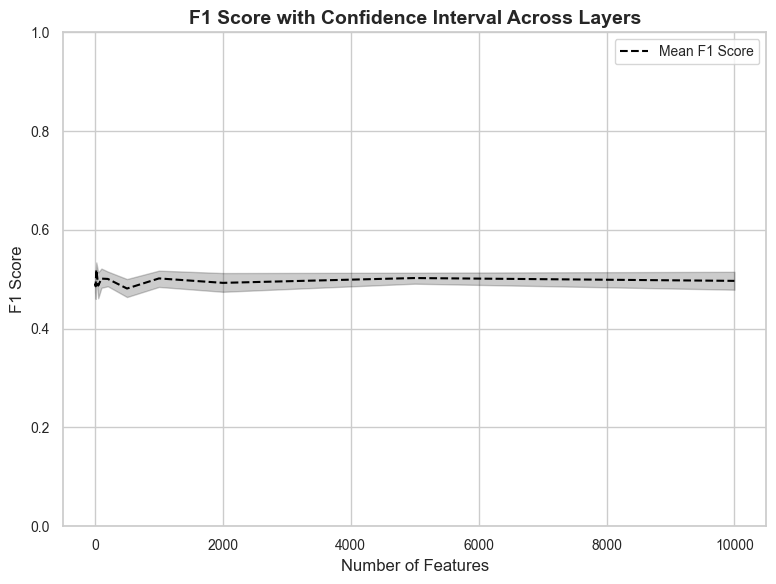

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for better aesthetics
sns.set_style("whitegrid")

from dataclasses import dataclass

@dataclass
class Metric:
    name: str
    label: str

F1 = Metric("f1", "F1 Score")
ACCURACY = Metric("accuracy", "Accuracy")

ACTIVE_METRIC = F1

# Create the figure
plt.figure(figsize=(8, 6))

# Plot mean F1 score across all layers with confidence interval
sns.lineplot(data=main_df, x="n_features", y=ACTIVE_METRIC.name, ci=95, label=f"Mean {ACTIVE_METRIC.label}", color="black", linestyle="dashed")

# Plot Layer 11
# df_11 = main_df[main_df["layer"] == "11"]
# plt.plot(df_11["n_features"], df_11[ACTIVE_METRIC.name], label="Layer 11", color="red", linestyle="-",alpha=0.3)

# # Plot Layer 1
# df_1 = main_df[main_df["layer"] == "1"]
# plt.plot(df_1["n_features"], df_1[ACTIVE_METRIC.name], label="Layer 1", color="blue", linestyle="-",alpha=0.3)

# Labels and title
plt.xlabel("Number of Features", fontsize=12)
plt.ylabel(ACTIVE_METRIC.label, fontsize=12)
plt.title(f"{ACTIVE_METRIC.label} with Confidence Interval Across Layers", fontsize=14, fontweight="bold")

# Add a legend
plt.legend(fontsize=10)

# Improve layout
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

#define axis limits
plt.ylim(0, 1)

# Show the plot
plt.show()
